# Get the Data

이제 직접 코드로 구현해보자.

전체 jupyter notebook code는 https://github.com/ageron/handson-ml2 에서 찾을 수 있다.

## Download the Data

웹 브라우저에서 직접 데이터를 내려받을수도 있지만, 짧은 함수로 구현하는 것을 추천한다.

이는 데이터가 정기적으로 바뀌는 경우, 최신의 데이터로 계속해서 fetch하기에도 좋으며 여러 기기에서 데이터셋을 내려받아야 하는 경우에도 유용하기 때문이다.

In [1]:
import os
import tarfile
from six.moves import urllib

download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_url = download_root + "datasets/housing/housing.tgz"

dataset_root = os.path.join(os.getcwd(), "datasets")
housing_path = os.path.join(dataset_root, "housing")

def fetch_housing_data(housing_url=housing_url, housing_path=housing_path):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

이제 `fetch_housing_data()`를 호출하면, ./datasets/housing 경로에 housing.csv파일을 생성할 것이다.

In [2]:
fetch_housing_data()

pandas로 data를 불러오는 함수를 구현해보자.

In [3]:
import pandas as pd

def load_housing_data(housing_path=housing_path):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

위 함수를 호출하면, 전체 데이터를 pandas DataFrame object로 반환할 것이다.

## Take a Quick Look at the Data Structure

DataFrame의 `head()`를 통해 첫 5행의 데이터를 살펴보자.

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


각 열은 하나의 district에 대한 정보이며, 총 10개의 feature가 있다.

`info()`를 사용하면 총 행의 갯수와 각 feature의 datatype, non-null value의 수와 같은 데이터의 정보를 알 수 있다.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


위 결과를 보면, 총 20640개의 instance가 있으며, `total_bedrooms`의 non-null count가 20433으로 207개의 district에서 결측치가 있다는 것을 알 수 있는데 이는 나중에 처리하기로 한다.

Dtype을 살펴보면, `ocean_proximity`만 수치 값이 아닌 것을 확인할 수 있다. datatype이 `object`이므로 어떠한 Python object라도 될 수 있지만 csv 파일에서 데이터를 읽어왔으므로 text 속성일 것이다. 또한, `head()`의 출력을 통해 `ocean_proximity`에 같은 값이 반복된다는 것을 알 수 있으므로 이는 아마 categorical feature일 것으로 예상할 수 있다.

`value_counts()`를 사용하면 어떤 category가 얼마나 있는지를 알 수 있다.

In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

`describe()`는 수치 값 feature에 대한 summary를 보여준다.

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


`total_bedrooms`의 `count`가 20433이므로, null값은 무시된 것을 알 수 있다.

`count`, `mean`, `min`, `max`는 의미 그대로이며 `std`행은 측정 값이 얼마나 흩어져 있는지를 나타내는 표준편차를 의미한다.

`25%`, `50%`, `75%`행은 측정값을 낮은 순에서 높은 순으로 정렬한 후, 4등분 했을 때 각 등위에 해당하는 값을 의미한다. 예를 들어, 25%의 districts는 `housing_median_age`가 18보다 낮으며, 50%의 districts는 29보다 낮고, 75%의 district는 37보다 낮다.

데이터의 형태를 빨리 살펴보기 위한 좋은 방법은 수치 값인 feature의 histogram을 그려보는 것이다. histogram은 수직 축에 instance의 수를 나타내고, 수평 축에 값의 범위를 나타낸다. histogram은 `hist()`를 통해 그릴 수 있다.

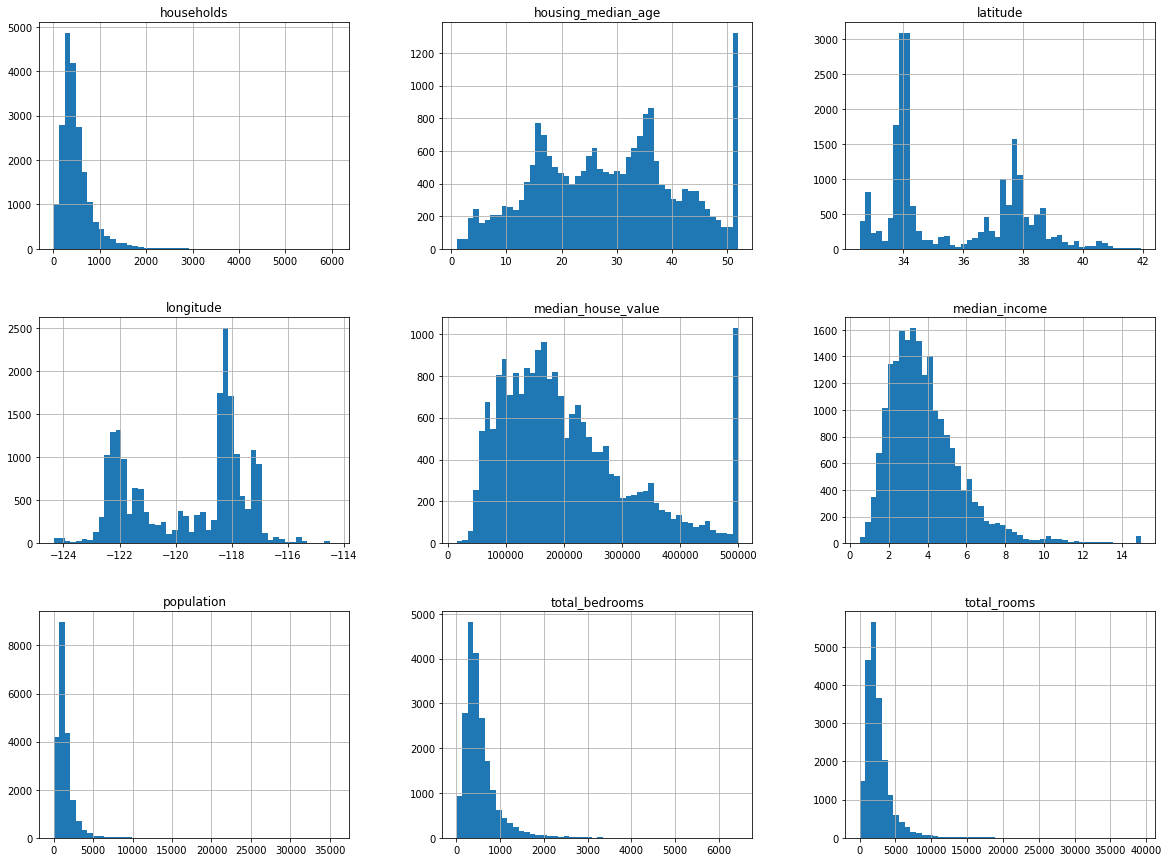

In [8]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

위의 histogram에서 다음과 같은 것을 발견할 수 있다:

1. `median_income`이 US dollar(USD) 단위가 아닌것 처럼 보인다. 데이터를 수집한 곳에 따르면 스케일이 조정된 후, 최대 15(실제로는 15.0001), 최소 0.5(실제로는 0.4999)의 범위로 조정되었다고 한다. 머신러닝에서는 이와 같은 preprocessing된 데이터가 실제로 어떻게 계산된 것인지 이해하고 있어야 한다.
2. `housing_median_age`와 `median_house_value` 또한 마지막 값의 막대가 치솟은 것으로 보아 최대 값이 제한되었다는 것을 알 수 있다. `median_house_value`는 target으로 사용되므로, 나중에 심각한 문제가 될 수 있다. 만약, 머신러닝 시스템이 50(500000달러)이상의 가격을 정확히 예측해야 한다면, 다음의 2가지 선택지가 있다.
    1. 최대 값 이상의 정확한 값을 수집한다.
    2. training 및 test 데이터에서 최대 값을 넘는 district를 제거한다.
3. 각 feature들은 범위가 서로 다르다. 이는 나중에 feature scaling에 대해 배우는 장에서 다룰 것이다.
4. 많은 histogram이 중앙이 아닌 왼쪽 또는 오른쪽으로 치우쳐 있다. 이는 머신러닝 알고리즘이 패턴을 감지하기 어렵게 만든다. 따라서 이후 이를 종 모양의 분포를 가지도록 변환할 것이다.

## Create a Test Set
데이터를 직접 본 후에 test set을 분리하면, 우리의 뇌가 감지한 패턴이 test set 분리에 영향을 미칠 수 있으므로(이를 **data snooping** bias라 한다), 데이터를 분석하기 전에 test set을 분리한다.


이론적으로, test set을 만드는 것은 아주 간단하다. 무작위로 instance를 20% 떼어놓으면 된다. 

In [9]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), len(test_set))

16512 4128


위의 코드는 동작하지만, 매 프로그램 실행 시마다 다른 test set을 생성하므로 문제가 있다.

이를 위한 해결책으로는 첫 실행 시에 test set을 저장하는 방법과 `np.random.permutation()` 전에 `np.random.seed(42)`와 같이 random seed를 설정하는 방법이 있다. 하지만 이 2가지 방법도 dataset이 업데이트 된다면 문제가 된다.

따라서, 더욱 일반적인 해결책으로는, 각 instance의 identifier를 통해 test set의 유무를 결정하는 것이다.(instance들이 각자의 고유하고 변경 불가능한 identifier를 가지고 있다고 가정)

예를 들어, 각 instance의 identifier로 해시를 계산해서 최대 해시 값의 20% 이하일 경우 test set으로 하는 방법이 있다. 이는 dataset이 새로 업데이트 되더라도 test set은 20%로 일정하게 유지시켜 준다. 업데이트된 test set에는 새 instance의 20%가 포함되고 이전 instance의 training set은 포함되지 않는다.

다음은 이를 구현한 코드이다.

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

하지만 여기서 사용하는 housing dataset에는 identifier column이 없으므로, 다음과 같이 간단히 row index를 ID를 index로 사용할 수 있다.

In [11]:
housing_with_id = housing.reset_index() # index column 추가
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

하지만 위처럼 row index를 ID로 사용하려면, 새로운 데이터는 항상 dataset의 마지막에 추가되어야 하며, row는 절대 지워지지 않아야 한다.

그렇지 못하다면, 가장 stable한 feature를 사용해 identifier를 생성하는 방법도 있다. 예를 들어, district의 latitude와 longitude는 수백년간 거의 변하지 않으므로 이를 혼합해서 다음과 같이 사용할 수 있다.

In [12]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

사이킷런은 dataset을 분리하는 몇가지 함수를 제공하며 가장 간단한 함수는 `train_test_split()`이다. 이 함수는 앞서 정의한 split_train_test와 매우 유사하지만 다음의 두가지 특징이 더 있다.
1. `random_state` 파라미터로 random seed를 받는다.
2. 행의 갯수가 같은 여러 dataset을 전달하면 이를 동일한 index를 기반으로 분리할 수 있다.(이는 label별로 분리된 DataFrame을 가지고 있는 경우에 매우 유용하다.)

In [13]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

지금까지는 purely random sampling 방법을 고려하였다. 만약 dataset이 충분히 크다면, 이는 일반적으로 잘 동작하지만 그렇지 않다면, sampling bias가 생길 가능성이 크다.

예를 들어, 인구의 51.3%가 여성이고, 48.7%가 남성이고, 1000명을 대상으로 설문조사를 실시한다면 1000명에 대해서도 이 비율이 유지되어야하므로 여성은 513명, 남성은 487명이 되어야한다.

이를 ***stratified sampling***(계층적 샘플링)이라고 한다 : 전체 모집단은 *strata*(계층)라고 하는 동종 하위 그룹(homogeneous subgroup)으로 나뉘며 test set이 전체 모집단을 representative하도록 각 strata에서 올바른 수의 instance를 sampling하는 방법이다.

`median_income`이 median housing price를 예측하는데 매우 중요한 feature라고 가정하면 test set은 전체 dataset의 다양한 income category를 representative해야 한다. 따라서, 이를 기준으로 stratified sampling을 적용해본다.

`median_income`은 연속적인 수치 값이므로, 먼저, income category feature를 만들어야 한다. `median_income`의 histogram을 보면, 대부분은 2~5이지만 몇몇 값들은 6을 넘는다. dataset의 stratum별로 충분한 instance가 있지 않다면 stratum의 중요도 평가에 bias가 생길 것이다. 따라서, 너무 많은 strata로 나누면 안되며, 각 strata가 충분히 커야 한다.

아래 코드는 median income을 1.5로 나눈 후 올림하고, 5를 넘는 값은 5로 제한하여 income category feature를 만든다.

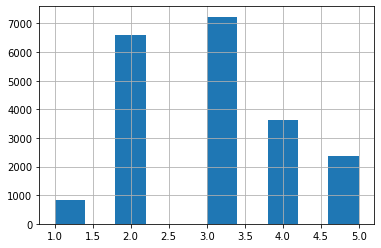

In [14]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

housing["income_cat"].hist()

이제 income category에 기반해서 startified sampling을 해보자. 이는 사이킷런의 `StratifiedShuffleSplit`을 통해 수행할 수 있다.

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
    print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


전체 dataset의 income category의 비율에 대해서 Stratified sampling과 purely random sampling을 비교해보면 다음과 같다.

In [16]:
from sklearn.model_selection import train_test_split

print("Full dataset")
print(housing["income_cat"].value_counts() / len(housing))
print('')

print("Purely random sampling")
_, random_test_set = train_test_split(housing,
                                       test_size=0.2,
                                       random_state=42)
print(random_test_set["income_cat"].value_counts() / len(random_test_set))
print('')

print("Stratified sampling")
print(strat_test_set["income_cat"].value_counts() / len(strat_test_set))

Full dataset
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

Purely random sampling
3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

Stratified sampling
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


위 결과를 보면, stratified sampling이 purely random sampling보다 전체 dataset 비율에 더욱 근접하다는 것을 알 수 있다.

마지막으로, `income_cat` feature를 지워서 원래대로 만들어준다.

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)